In [14]:
import sys
sys.path.append(r'C:\Users\Gosia\Desktop\FDR-Metabolomics\src\passatutto_parser.py')
import passatutto_parser as pp

In [15]:
pre_spectrums = pp.PassatuttoParser(r'C:\Users\Gosia\Downloads\MassbankOrbi').parse_folder()

processed 100 files
processed 200 files
processed 300 files
processed 400 files
Finished parsing of 457 spectra 


In [3]:
from pprint import pprint
pprint(pre_spectrums[0])

{'adduct': '[M+H]+',
 'charge': 1,
 'compound_name': 'Acamprosate',
 'formula_smiles': 'C5H11NO4S',
 'inchi': 'InChI=1S/C5H11NO4S/c1-5(7)6-3-2-4-11(8,9)10/h2-4H2,1H3,(H,6,7)(H,8,9,10)',
 'instrument': 'LTQ Orbitrap XL Thermo Scientific',
 'parent_mass': 182.0482,
 'peaks_json': [[58.0651, 9230.4],
                [59.0491, 8262.0],
                [100.0756, 3969.7],
                [122.0272, 3243.7],
                [123.011, 90917.6],
                [140.0376, 17074.2],
                [58.0651, 6595.5],
                [59.0491, 10267.6],
                [100.0756, 23581.3],
                [122.0269, 14661.9],
                [123.011, 363161.2],
                [140.0376, 492845.9],
                [58.065, 3497.2],
                [59.0493, 7641.8],
                [100.0757, 46941.1],
                [122.0269, 15808.6],
                [123.011, 295065.8],
                [140.0376, 1862696.7],
                [182.0483, 28342.8],
                [123.0113, 13818.1],
        

In [4]:
from matchms.importing.load_from_json import as_spectrum
spectrums = []
for i, s in enumerate( pre_spectrums ):
    spectrums.append(as_spectrum(s))
    if i and i % 10 == 0:
        print('processed %d', i)

processed %d 10
processed %d 20
processed %d 30
processed %d 40
processed %d 50
processed %d 60
processed %d 70
processed %d 80
processed %d 90
processed %d 100
processed %d 110
processed %d 120
processed %d 130
processed %d 140
processed %d 150
processed %d 160
processed %d 170
processed %d 180
processed %d 190
processed %d 200
processed %d 210
processed %d 220
processed %d 230
processed %d 240
processed %d 250
processed %d 260
processed %d 270
processed %d 280
processed %d 290
processed %d 300
processed %d 310
processed %d 320
processed %d 330
processed %d 340
processed %d 350
processed %d 360
processed %d 370
processed %d 380
processed %d 390
processed %d 400
processed %d 410
processed %d 420
processed %d 430
processed %d 440
processed %d 450


In [9]:
len(spectrums)

458

In [11]:
d = {s.get('compound_name'):s for s in spectrums}
len(d)

454

In [13]:
from collections import Counter
c = Counter( s.get('compound_name') for s in spectrums )
names = [ n for n,_ in c.most_common(4) ]
for s in spectrums:
    if s.get('compound_name') in names:
        print( s.get('compound_name'), s.get('inchi') )

Erythromycin InChI=1S/C37H67NO13/c1-14-25-37(10,45)30(41)20(4)27(39)18(2)16-35(8,44)32(51-34-28(40)24(38(11)12)15-19(3)47-34)21(5)29(22(6)33(43)49-25)50-26-17-36(9,46-13)31(42)23(7)48-26/h18-26,28-32,34,40-42,44-45H,14-17H2,1-13H3/t18-,19-,20+,21+,22-,23+,24+,25-,26+,28-,29+,30-,31+,32-,34+,35-,36-,37-/m1/s1
Reserpine InChI=1S/C33H40N2O9/c1-38-19-7-8-20-21-9-10-35-16-18-13-27(44-32(36)17-11-25(39-2)30(41-4)26(12-17)40-3)31(42-5)28(33(37)43-6)22(18)15-24(35)29(21)34-23(20)14-19/h7-8,11-12,14,18,22,24,27-28,31,34H,9-10,13,15-16H2,1-6H3
Adenosine InChI=1S/C10H13N5O4/c11-8-5-9(13-2-12-8)15(3-14-5)10-7(18)6(17)4(1-16)19-10/h2-4,6-7,10,16-18H,1H2,(H2,11,12,13)/t4-,6-,7-,10-/m1/s1
Erythromycin InChI=1S/C37H67NO13/c1-14-25-37(10,45)30(41)20(4)27(39)18(2)16-35(8,44)32(51-34-28(40)24(38(11)12)15-19(3)47-34)21(5)29(22(6)33(43)49-25)50-26-17-36(9,46-13)31(42)23(7)48-26/h18-26,28-32,34,40-42,44-45H,14-17H2,1-13H3/t18-,19-,20+,21+,22-,23+,24+,25-,26+,28-,29+,30-,31+,32-,34+,35-,36-,37-/m1/s1
Reserpi

In [41]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

print("{} remaining spectra.".format(len(spectrums)))

4053 remaining spectra.


In [42]:
import bisect
import numpy as np
# a filter to check if there is a fragment within N ppm of the precursor
def has_frag(spectrum, mz, tol, tol_units='absolute'):
    if tol_units == 'ppm':
        di = tol_ppm*mz/1e6
    else:
        di = tol
    min_mz = mz - di
    max_mz = mz + di
    pos = bisect.bisect_right(spectrum.peaks[0], min_mz)
    pos2 = bisect.bisect_right(spectrum.peaks[0], max_mz)
    if pos == pos2:
        return None
    else:
        max_pos = pos + np.argmax(spectrum.peaks[1][pos:pos2])
        return (spectrum.peaks[0][max_pos], spectrum.peaks[1][max_pos])

In [43]:
spec_with_precursor = [s for s in spectrums if has_frag(s, s.metadata['precursor_mz'], 0.2)  is not None]

In [44]:
print(len(spec_with_precursor))

2682


In [45]:
inchi_dict = {}
for s in spec_with_precursor:
    ik = s.metadata['inchikey']
    if not ik in inchi_dict:
        inchi_dict[ik] = [s]
    else:
        inchi_dict[ik].append(s)

In [46]:
library_spec = set()
query_spec = set()
singletons = set([i for i,v in inchi_dict.items() if len(v) == 1])
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])
print(len(singletons), len(multis))

1475 467


In [48]:
query_size = 400
library_size = 1000

In [49]:
used = set()
query_keys = np.random.choice(list(multis), size=query_size, replace=False)
other_library_keys = np.random.choice(list(singletons), size=library_size-query_size, replace=False)
query_spec = []
library_spec = []
for q in query_keys:
    ss = np.random.choice(inchi_dict[q], size=2, replace=False)
    query_spec.append(ss[0])
    library_spec.append(ss[1])
for o in other_library_keys:
    ss = np.random.choice(inchi_dict[o], size=1, replace=False)
    library_spec.append(ss[0])

assert len(library_spec) == library_size
assert len(query_spec) == query_size

In [50]:
# compute similarities between query and library spec

In [51]:
from matchms.similarity import CosineGreedy
cs = CosineGreedy(0.2)

In [52]:
library_spec.sort(key = lambda x: x.metadata['precursor_mz'])

In [53]:
def query(query_spec, library_spec, precursor_tol = 1):
    hits = []
    library_prec_list = [x.metadata['precursor_mz'] for x in library_spec]
    for q in query_spec:
        min_mz = q.metadata['precursor_mz'] - precursor_tol
        max_mz = q.metadata['precursor_mz'] + precursor_tol
        pos = bisect.bisect_right(library_prec_list, min_mz)
        pos2 = pos
        while library_prec_list[pos2]  < max_mz:
            pos2 += 1
        if pos == pos2:
            # nothing in precursor range
            hits.append((q, None, None))
        else:
            scores = []
            for l in library_spec[pos:pos2]:
                s,_ = cs.pair(l,q)
                scores.append((s, l))
            scores.sort(key = lambda x: x[0], reverse=True)
            hits.append((q, scores[0][0], scores[0][1]))
    return hits
hits = query(query_spec, library_spec)

In [54]:
hits = list(filter(lambda x: x[1] is not None, hits))
hits.sort(key = lambda x: x[1], reverse=True)
q,s,l = zip(*hits)

(array([ 11.,   4.,  10.,  11.,   8.,   8.,  13.,  11.,   9.,   7.,  17.,
          8.,  12.,  18.,  21.,  15.,  18.,  22.,  27., 137.]),
 array([4.98313306e-04, 5.04611373e-02, 1.00423961e-01, 1.50386785e-01,
        2.00349609e-01, 2.50312433e-01, 3.00275257e-01, 3.50238081e-01,
        4.00200905e-01, 4.50163730e-01, 5.00126554e-01, 5.50089378e-01,
        6.00052202e-01, 6.50015026e-01, 6.99977850e-01, 7.49940674e-01,
        7.99903498e-01, 8.49866322e-01, 8.99829146e-01, 9.49791970e-01,
        9.99754794e-01]),
 <BarContainer object of 20 artists>)

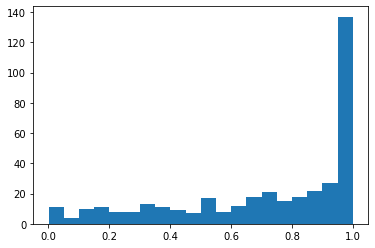

In [55]:
import pylab as plt
%matplotlib inline
plt.hist(s, bins=20)

In [56]:
def make_all_peaks(library):
    all_peak_mz = []
    all_peak_intensity = []
    all_spec = []
    for s in library:
        mz_list = list(s.peaks[0])
        all_peak_mz += mz_list
        intensity_list = list(s.peaks[1])
        all_peak_intensity += intensity_list
        all_spec += [s for m in mz_list]
    return list(zip(all_peak_mz, all_peak_intensity, all_spec))

In [57]:
all_peaks = make_all_peaks(library_spec)
all_peaks.sort(key = lambda x: x[0])
all_mz, all_intensity, all_s = zip(*all_peaks)
print(len(all_peaks))

115073


In [58]:
from matchms.Spectrum import Spectrum
import copy
def create_random_decoy(spectrum, all_mz, all_intensity):
    n_peaks = len(all_mz)
    precursor_mz = spectrum.metadata['precursor_mz']
    (pmz,pi) = has_frag(spectrum, precursor_mz, 0.2)
    mz = []
    intensity = []
    mz.append(pmz)
    intensity.append(pi)
    
    n_peaks = len(spectrum.peaks[0]) - 1
    max_pos = bisect.bisect_right(all_mz, precursor_mz)
    pos = np.random.choice(range(max_pos), size=n_peaks, replace=False)
    
    for p in pos:
        mz.append(all_mz[p])
        intensity.append(all_intensity[p])
    
    idx = np.argsort(mz)
    mz = np.array(mz)
    intensity = np.array(intensity)
    mz = mz[idx]
    intensity = intensity[idx]
    
    new_spectrum = Spectrum(np.array(mz), np.array(intensity), copy.deepcopy(spectrum.metadata))

    return new_spectrum

decoy_library = []
for l in library_spec:
    spec = create_random_decoy(l, all_mz, all_intensity)
    decoy_library.append(spec)

In [59]:
def create_spectral_decoy(spectrum, all_mz, all_intensity, all_s):
    precursor_mz = spectrum.metadata['precursor_mz']
    (pmz,pi) = has_frag(spectrum, precursor_mz, 0.2)
    mz = []
    intensity = []
    
    new_mz = pmz
    new_intensity = pi
    possible_peaks = []
    
    
    n_peaks = len(spectrum.peaks[0])
    for i in range(n_peaks):
        mz.append(new_mz)
        intensity.append(new_intensity)
    
        # find all spectra with something within 0.2
        min_mz = new_mz - 0.2
        max_mz = new_mz + 0.2
        pos = bisect.bisect_right(all_mz, min_mz)
        pos2 = bisect.bisect_right(all_mz, max_mz)
        assert pos2 > pos
        N = min(5, pos2 - pos)
        pos = np.random.choice(range(pos,pos2), size=N, replace=False)
        for p in pos:
            spec = all_s[p]
            max_pos = bisect.bisect_right(spec.peaks[0], pmz)
            if max_pos > 0:
                peak_pos = np.random.choice(max_pos)
                possible_peaks.append((spec.peaks[0][peak_pos], spec.peaks[1][peak_pos]))
        next_peak_idx = np.random.choice(len(possible_peaks))
        next_peak = possible_peaks[next_peak_idx]
        del possible_peaks[next_peak_idx]
        new_mz = next_peak[0]
        new_intensity = next_peak[1]
        
        
    idx = np.argsort(mz)
    mz = np.array(mz)
    intensity = np.array(intensity)
    mz = mz[idx]
    intensity = intensity[idx]

    new_spectrum = Spectrum(np.array(mz), np.array(intensity), copy.deepcopy(spectrum.metadata))

    return new_spectrum
    
create_spectral_decoy(library_spec[0], all_mz, all_intensity, all_s)

In [26]:
spec_library = []
for i,l in enumerate(library_spec):
    if i%100 == 0:
        print(i,len(library_spec))
    spec = create_spectral_decoy(l, all_mz, all_intensity, all_s)
    spec_library.append(spec)

0 2000
100 2000
200 2000
300 2000
400 2000
500 2000
600 2000
700 2000
800 2000
900 2000
1000 2000
1100 2000
1200 2000
1300 2000
1400 2000
1500 2000
1600 2000
1700 2000
1800 2000
1900 2000


In [60]:
decoy_hits = query(query_spec, decoy_library)

In [61]:
spec_decoy_hits = query(query_spec, spec_library)

In [62]:
decoy_hits = list(filter(lambda x: x[1] is not None, decoy_hits))
decoy_hits.sort(key = lambda x: x[1], reverse=True)
q,s,l = zip(*decoy_hits)

(array([34., 48., 48., 29., 28., 23., 23., 16., 17., 15., 12., 14., 14.,
        10., 10., 10., 12.,  7., 14.,  8.]),
 array([0.        , 0.04978225, 0.0995645 , 0.14934675, 0.199129  ,
        0.24891125, 0.2986935 , 0.34847575, 0.398258  , 0.44804025,
        0.4978225 , 0.54760475, 0.597387  , 0.64716925, 0.6969515 ,
        0.74673375, 0.796516  , 0.84629825, 0.8960805 , 0.94586275,
        0.995645  ]),
 <BarContainer object of 20 artists>)

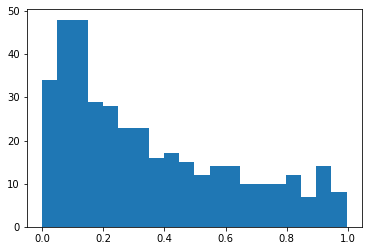

In [63]:
spec_decoy_hits = list(filter(lambda x: x[1] is not None, spec_decoy_hits))
spec_decoy_hits.sort(key = lambda x: x[1], reverse=True)
q,s,l = zip(*spec_decoy_hits)

plt.hist(s, bins=20)

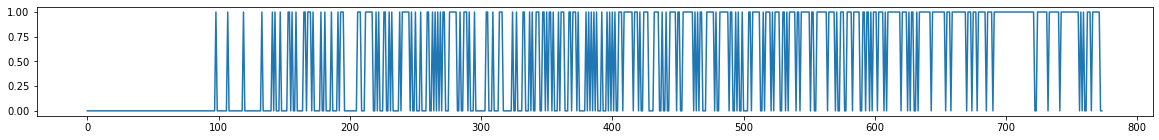

In [64]:
# table 1, columns are score, db (target/decoy)
fdr_table = []
for h in hits:
    fdr_table.append((h[0], h[1], 0))
for h in decoy_hits:
    fdr_table.append((h[0], h[1], 1))
fdr_table.sort(key = lambda x: x[1], reverse = True)
q, s, ss = zip(*fdr_table)
plt.figure(figsize=(20,2))
plt.plot(range(len(ss)), ss)

In [65]:
def fdr_q(fdr_table):
    fdr_table.sort(key=lambda x: x[1], reverse=True)
    fdr_vals = []
    queries,s,ss = zip(*fdr_table)
    for i in range(len(fdr_table)):
        fdr = sum(ss[:i])/(i+1)
        fdr_vals.append(fdr)
    q_vals = [0 for f in fdr_vals]
    q_vals[-1] = fdr_vals[-1]
    for i in range(len(q_vals)-2,0,-1):
        q_vals[i] = min(fdr_vals[i],q_vals[i+1])
    q_list = []
    for i,q in enumerate(queries):
        if ss[i] == 0: # i.e. the true one
            q_list.append((q, q_vals[i]))
    return fdr_vals, q_vals, q_list

In [66]:
fdr_vals, q_vals, q_list = fdr_q(fdr_table)

In [67]:
# table 1, columns are score, db (target/decoy)
spec_fdr_table = []
for h in hits:
    spec_fdr_table.append((h[0], h[1], 0))
for h in spec_decoy_hits:
    spec_fdr_table.append((h[0], h[1], 1))
spec_fdr_table.sort(key = lambda x: x[1], reverse = True)
spec_fdr_vals, spec_q_vals, spec_q_list = fdr_q(spec_fdr_table)

In [68]:
# make the true one
true_fdr_table = []
for h in hits:
    # check if it is correct
    query_ik = h[0].metadata['inchikey']
    library_ik = h[2].metadata['inchikey']
    if query_ik == library_ik:
        false = 0
    else:
        false = 1
    true_fdr_table.append((h[0], h[1], false))
true_fdr, true_q, true_q_list = fdr_q(true_fdr_table)

In [69]:
# find the pairs for the plot
plot_true = []
plot_estimated = []
spec_plot_estimated = []
qq,qqq = zip(*q_list)
spec_qq, spec_qqq = zip(*spec_q_list)
for qs, qval in true_q_list:
    assert qs in qq
    pos = qq.index(qs)
    plot_true.append(qval)
    plot_estimated.append(qqq[pos])
    pos = spec_qq.index(qs)
    spec_plot_estimated.append(spec_qqq[pos])

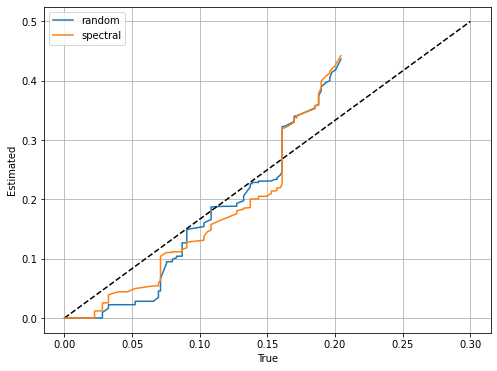

In [70]:
plt.figure(figsize=(8,6))
plt.plot(plot_true, plot_estimated, label='random')
plt.plot([0,0.5], [0,0.5], 'k--')
plt.plot(plot_true, spec_plot_estimated, label='spectral')
plt.xlabel('True')
plt.ylabel('Estimated')
plt.legend()
plt.grid()